In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn meteostat jupyter kagglehub

https://quickstats.nass.usda.gov/results/C3DBB93E-6248-3178-82D2-C30152D59B49
Good source for data!

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meongsuzacklee/us-corn-data")

print("Path to dataset files:", path)

#just ignore this tbh
#i already have the actual csv locally



100%|██████████| 12.3k/12.3k [00:00<00:00, 4.67MB/s]

Extracting files...
Path to dataset files: C:\Users\idesh\.cache\kagglehub\datasets\meongsuzacklee\us-corn-data\versions\1


In [ ]:
from datetime import datetime

stations = Stations()
stations = stations.region('US', 'IN')
stations = stations.inventory(
    'daily',
    (datetime(1980, 1, 1), datetime(2022, 12, 31))
)

stations = stations.fetch()
print(stations.head())


                                      name country region    wmo  icao  \
id                                                                       
72432                  Evansville Regional      US     IN  72432  KEVV   
72438  Indianapolis International  Airport      US     IN  72438  KIND   
72533             Fort Wayne International      US     IN  72533  KFWA   
72535          South Bend Regional Airport      US     IN  72535  KSBN   

       latitude  longitude  elevation                      timezone  \
id                                                                    
72432   38.0333   -87.5333      127.0               America/Chicago   
72438   39.7167   -86.1167      243.0  America/Indiana/Indianapolis   
72533   41.0000   -85.0333      248.0  America/Indiana/Indianapolis   
72535   41.7000   -86.3167      244.0  America/Indiana/Indianapolis   

      hourly_start hourly_end daily_start  daily_end monthly_start monthly_end  
id                                             

In [ ]:
weather['year'] = weather.index.year
weather['month'] = weather.index.month

growing_season = weather[(weather['month'] >= 4) & (weather['month'] <= 9)]


annual_weather = growing_season.groupby('year').agg({
    'tavg': 'mean',
    'tmax': 'mean',
    'tmin': 'mean',
    'prcp': 'sum'
}).reset_index()

#tavg = average temperature
# tmax = maximum temperature
# tmin = minimum temperature
# prcp = precipitation

In [1]:
import pandas as pd
from meteostat import Point, Daily
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. LOAD KAGGLE DATA (Example for Indiana)
# Filter your Kaggle dataset for 'Indiana' and the years you have weather data for.
df_yield = pd.read_csv('us_state_corn.csv') 
df_in = df_yield[df_yield['State'] == 'INDIANA']

# 2. FETCH WEATHER DATA (Meteostat)
# Coordinates for a central Indiana point (e.g., Indianapolis)
location = Point(39.7684, -86.1581)


from meteostat import Daily, Stations

def get_seasonal_weather(year):
    # Specify a major station ID known for long-term historical data
    # '72438' is the WMO ID for Indianapolis International Airport
    station_id = '72438' 
    #Originally there weren't enough data points around central Indiana, so I used a major airport instead
    
    start = datetime(year, 5, 1)
    end = datetime(year, 9, 30)
    #Typical growing season for Indiana Corn
    
    # Fetch data directly by ID
    data = Daily(station_id, start, end).fetch()
    
    if data.empty:
        print(f"No data for year {year}")
        return pd.Series({'avg_temp': None, 'total_precip': None, 
                          'max_temp': None, 'heat_days': None})
    
    # Check for missing columns (sometimes small gaps occur)
    tavg = data['tavg'].mean() if 'tavg' in data else None
    prcp = data['prcp'].sum() if 'prcp' in data else None
    tmax = data['tmax'].max() if 'tmax' in data else None
    heat = (data['tmax'] > 30).sum() if 'tmax' in data else None

    return pd.Series({
        'avg_temp': tavg,
        'total_precip': prcp,
        'max_temp': tmax,
        'heat_days': heat
    })
#need to broaden search since the area around central Indiana  may not have data for all years


# This step essentially connects the previous weather data to yield data
weather_features = df_in['Year'].apply(get_seasonal_weather)
# Above fetches weather data for each year in the csv
df_final = pd.concat([df_in, weather_features], axis=1)
# Merge year, weather data, and yield

# 3. MODELING
X = df_final[['avg_temp', 'total_precip', 'max_temp', 'heat_days']]
df_final['yield'] = (
    df_final['CORN_PRODUCTION_BU'] /
    df_final['CORN_ACRES HARVESTED_ACRE']
)
y = df_final['yield'] # Make sure this column name matches your dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# 4. EVALUATE
preds = model.predict(X_test)
print(f"New R² Score: {r2_score(y_test, preds)}")

New R² Score: -2.509985453964193


In [15]:
# Check if the years actually match up
print(df_final[['Year', 'avg_temp', 'yield']].head(10))

# Check the correlation matrix
# If Year and Yield aren't highly correlated (> 0.7), something is wrong with the data
print(df_final[['Year', 'yield', 'total_precip']].corr())

     Year   avg_temp  yield
10   2022  22.331373  190.0
51   2021  21.816340  195.0
92   2020  21.501307  187.0
133  2019  22.309150  169.0
174  2018  23.444444  189.0
215  2017  21.398693  180.0
256  2016  22.298039  173.0
297  2015  21.784314  150.0
338  2014  20.405882  188.0
379  2013  21.598693  177.0
                  Year     yield  total_precip
Year          1.000000  0.602527      0.114255
yield         0.602527  1.000000      0.283719
total_precip  0.114255  0.283719      1.000000


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

# 1. Prepare Data
df_final['max_temp_sq'] = df_final['max_temp'] ** 2

# Include the squared term in your model
X = df_final[['Year', 'max_temp', 'max_temp_sq', 'total_precip']]
y = df_final['yield']

# 2. Use a Linear Model (better for small datasets)
model = LinearRegression()

# 3. Use Leave-One-Out Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)
print(f"Average RMSE: {rmse_scores.mean():.2f}")
#root mean square error
# On such a small set, look at RMSE rather than R²

Average RMSE: 11.88


In [5]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np


# 1. Prepare Data
# We keep the max_temp_sq, but Random Forest actually handles 
# non-linearities well even without it!
X = df_final[['Year', 'max_temp', 'max_temp_sq', 'total_precip']]
y = df_final['yield']

# 2. Initialize Random Forest
# For small datasets, we keep n_estimators high for stability 
# but keep max_depth low to prevent overfitting.
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=3,      # Small depth is key for small datasets
    random_state=42
)

# 3. Use Leave-One-Out Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(rf_model, X, y, cv=loo, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)
print(f"Random Forest Average RMSE: {rmse_scores.mean():.2f}")

Random Forest Average RMSE: 16.04


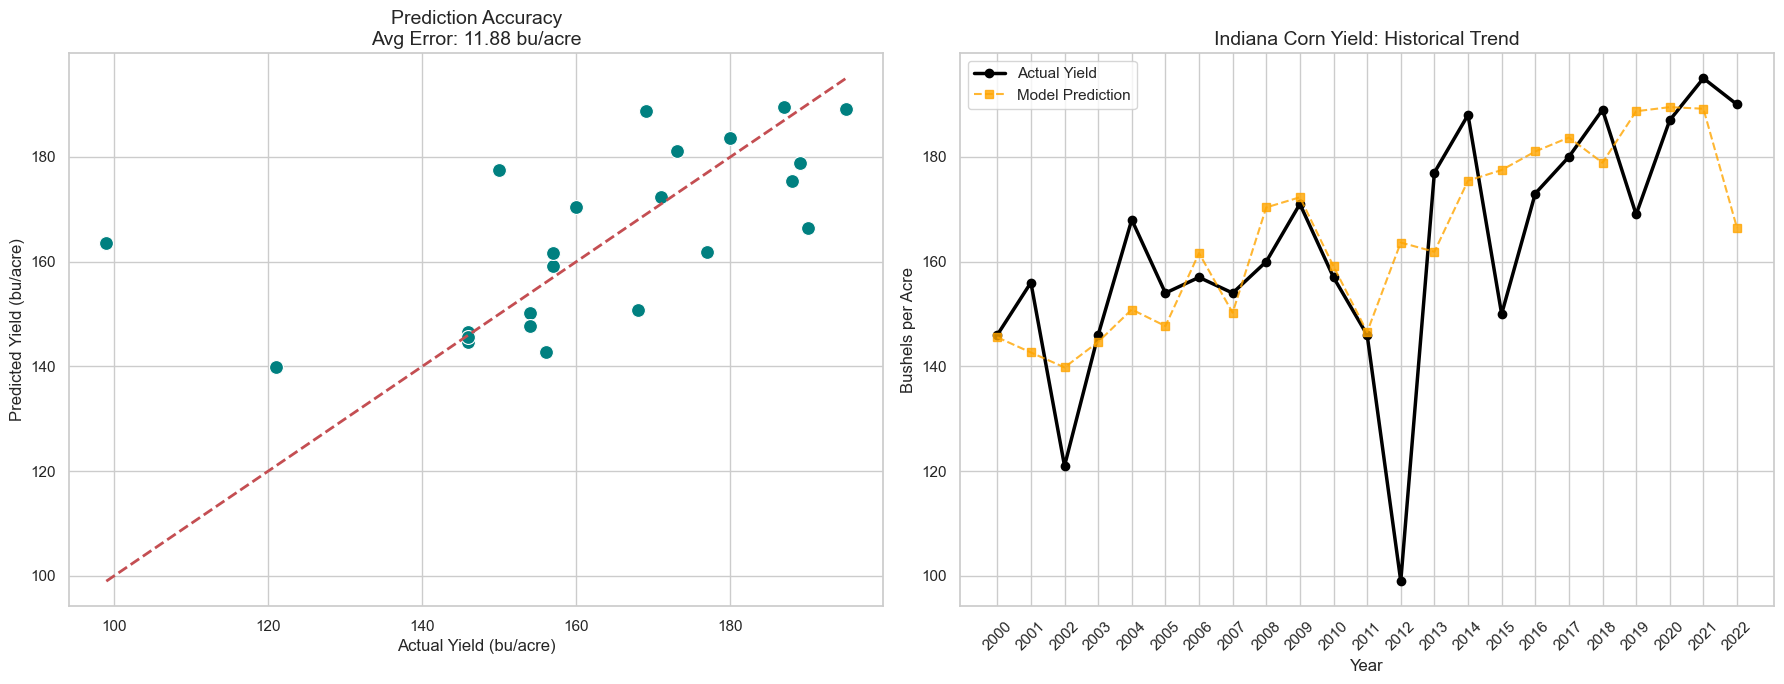

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict

# 1. Generate Predictions
y_pred = cross_val_predict(model, X, y, cv=loo)

# 2. Set the style
sns.set_theme(style="whitegrid")

# We increase the width to 18 to give the years more "breathing room"
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Actual vs Predicted ---
sns.scatterplot(x=y, y=y_pred, ax=axes[0], s=100, color='teal', edgecolor='w')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title(f'Prediction Accuracy\nAvg Error: {rmse_scores.mean():.2f} bu/acre', fontsize=14)
axes[0].set_xlabel('Actual Yield (bu/acre)', fontsize=12)
axes[0].set_ylabel('Predicted Yield (bu/acre)', fontsize=12)

# --- Plot 2: Yield Over Time (With Tilted Labels) ---
temp_plot_df = pd.DataFrame({
    'Year': df_final['Year'],
    'Actual': y,
    'Predicted': y_pred
}).sort_values('Year')

axes[1].plot(temp_plot_df['Year'], temp_plot_df['Actual'], marker='o', label='Actual Yield', color='black', linewidth=2.5)
axes[1].plot(temp_plot_df['Year'], temp_plot_df['Predicted'], marker='s', ls='--', label='Model Prediction', color='orange', alpha=0.8)

axes[1].set_title('Indiana Corn Yield: Historical Trend', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Bushels per Acre', fontsize=12)

# FIXING THE X-AXIS:
# 1. Set the ticks to be every year present in the data
axes[1].set_xticks(temp_plot_df['Year'])

# 2. Tilt the labels 45 degrees so they don't overlap
axes[1].tick_params(axis='x', rotation=45)

axes[1].legend(frameon=True, loc='upper left')

plt.tight_layout()
plt.show()

Actual yield showed a HUGE dip in 2012. A quick search confirms this, and this was due to significant droughts and heat.

So it also looks like corn is very sensitive to heat. So, I'm re-training the model to put more emphasis on the average max temp.

"Data from Nebraska showed the yield of dryland corn may be reduced 1 1/2 bushel per acre for each day the temperature reaches 95 F (35 C), or higher, during this critical period."
Source: https://www.extension.purdue.edu/extmedia/nch/nch-40.html

So, put a squared emphasis on max temps at or above ~35C.
